In [1]:
import string
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from plot_utils import plot_mean_feature_per_well


In [2]:
figsave_path = "output/plate_visualizations"

# features = ["Cells_AreaShape_Area", "Cells_Intensity_MeanIntensity_AGP"]
features = ["Image_Threshold_SumOfEntropies_CellsIncludingEdges"]

In [3]:
# profiles = pd.read_parquet("output/subset_profiles_cc_well_corrected.parquet")

profiles = {
    "raw_profiles":  "../1.load/output/raw_filtered_profiles.parquet",
    "cc_adj_profiles": "../3.correct/output/profiles_cc_adjusted.parquet",
    "well_mean_subtracted": "../3.correct/output/full_profiles_mean_corrected.parquet",
    "cc_adj_well_mean_subtracted": "../3.correct/output/full_profiles_cc_adj_mean_corr.parquet"
}

# profiles = pd.read_parquet("output/subset_profiles_cc_corrected.parquet")
# profiles

raw_profiles Image_Threshold_SumOfEntropies_CellsIncludingEdges correlation with Cells_Count: 0.719204705093529


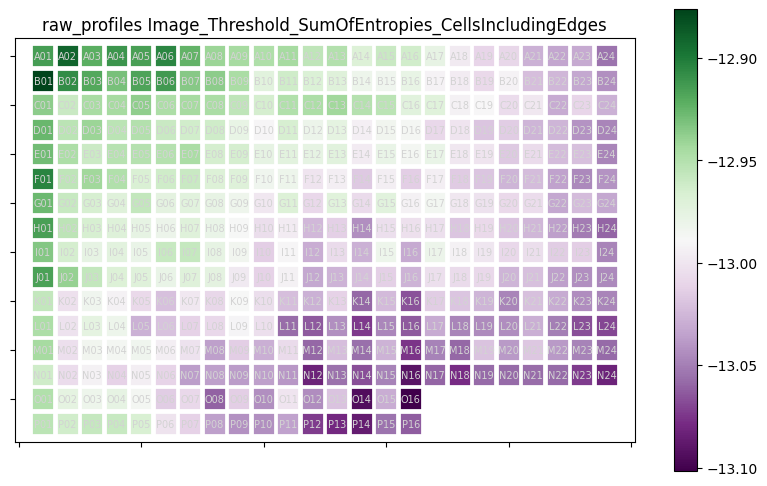

cc_adj_profiles Image_Threshold_SumOfEntropies_CellsIncludingEdges correlation with Cells_Count: 1.7748355453652667e-14


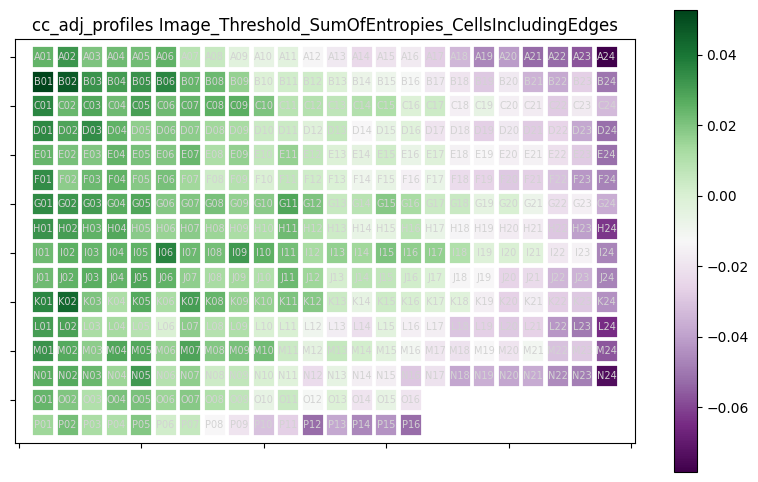

well_mean_subtracted Image_Threshold_SumOfEntropies_CellsIncludingEdges correlation with Cells_Count: 0.7018987967699475


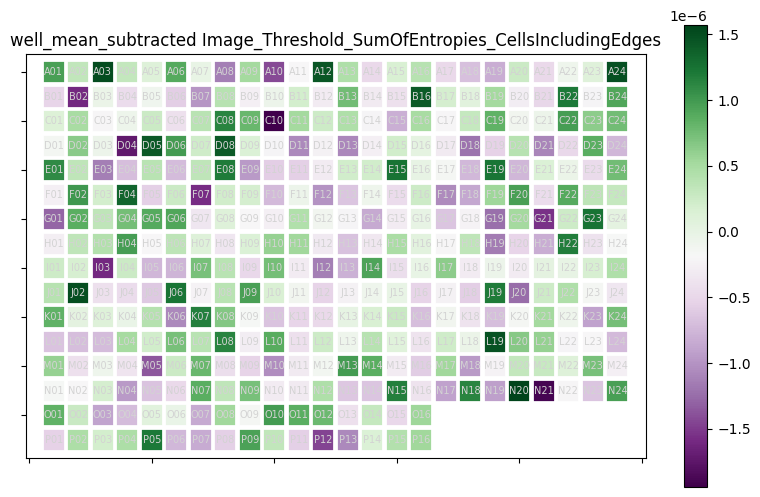

cc_adj_well_mean_subtracted Image_Threshold_SumOfEntropies_CellsIncludingEdges correlation with Cells_Count: -0.02691929814127445


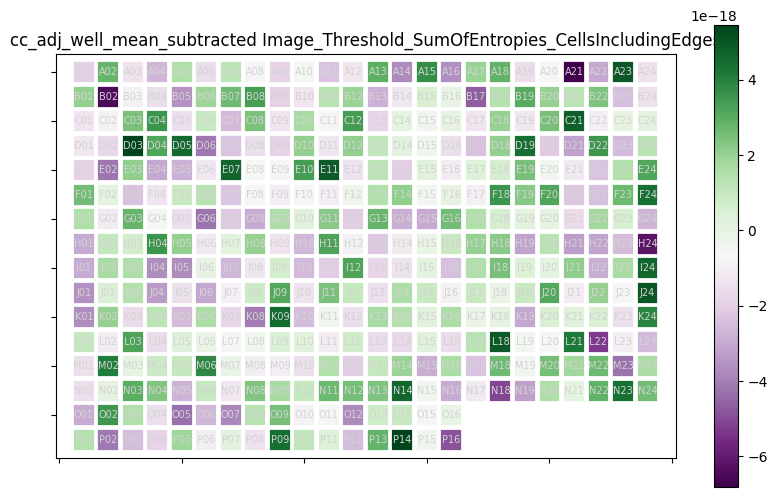

In [4]:
for p in profiles:
    df = pd.read_parquet(profiles[p])
    for feature in features:
        print(f"{p} {feature} correlation with Cells_Count: {df[feature].corr(df['Cells_Count'])}")
        plot_mean_feature_per_well(df, feature, prefix=p, figsave_path=figsave_path)
        plt.show()